# Regional activity time series visualizations
This example shows how to create visualizations of iNaturalist activity over time in a given region.
See https://www.inaturalist.org/places to find place IDs.

Visualization are made using [Altair](https://altair-viz.github.io), with the following metrics:
* Number of observations
* Number of taxa observed
* Number of observers
* Number of identifiers

In [1]:
from datetime import datetime
from time import sleep

from dateutil.relativedelta import relativedelta
from IPython.display import Image
from typing import Any, BinaryIO, Dict, Iterable, List, Optional, Tuple

import altair as alt
import pandas as pd

from pyinaturalist.node_api import (
    get_observations,
    get_observation_histogram,
    get_observation_species_counts,
    get_observation_observers,
    get_observation_identifiers,
)
from pyinaturalist.request_params import ICONIC_TAXA, get_interval_ranges

# Adjustable values
PLACE_ID = 6
PLACE_NAME = 'Alaska'
YEAR = 2020

THROTTLING_DELAY = 1.0  # Time to wait in between subsequent requests

### Show observation counts by year

In [2]:
observations_by_year = get_observation_histogram(
    place_id=PLACE_ID,
    interval='year',
    d1='2008-01-01',
    d2=f'{YEAR}-12-31',
    verifiable=True,
)
observations_by_year = pd.DataFrame([
    {'date': k, 'observations': v}
    for k, v in observations_by_year.items()
])
alt.Chart(observations_by_year).mark_bar().encode(x='year(date):T', y='observations:Q')

alt.Chart(...)

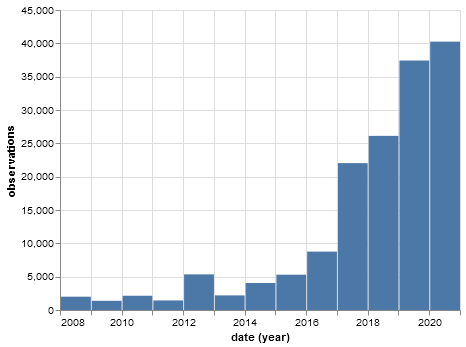

In [3]:
# Including the rendered image so the chart will display outside Jupyter, e.g. on GitHub's notebook viewer
Image('images/observations_by_year.png')

### Show observation counts by month

In [4]:
observations_by_month = get_observation_histogram(
    place_id=PLACE_ID,
    interval='month',
    d1='2020-01-02',
    d2='2020-12-31',
    verifiable=True,
)
observations_by_month = pd.DataFrame([
    {'metric': 'Observations', 'date': k, 'count': v}
    for k, v in observations_by_month.items()
])
alt.Chart(observations_by_month).mark_bar().encode(x='month(date):T', y='count:Q')

alt.Chart(...)

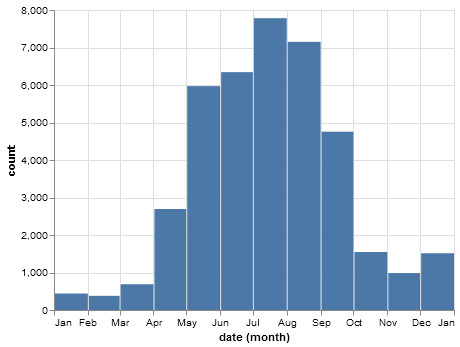

In [5]:
Image('images/observations_by_month.png')

### Making histograms for custom metrics
The API does not have a histogram endpoint for taxa observed, observers, or identifiers,
so we first need to determine our date ranges of interest, and then run one search per date range.

Here are a couple helper functions to make this easier:

In [6]:
def count_date_range_results(function, start_date, end_date):
    """Get the count of results for the given date range and search function"""
    # Running this search with per_page=0 will (quickly) return only a count of results, not complete results
    response = function(
        place_id=PLACE_ID,
        d1=start_date,
        d2=end_date,
        verifiable=True,
        per_page=0,
    )
    print(f'Total results for {start_date.strftime("%b")}: {response["total_results"]}')
    return response['total_results']
    if start_date.month != 12:
        sleep(THROTTLING_DELAY)


def get_monthly_counts(function, label):
    """Get the count of results per month for the given search function"""
    month_ranges = get_interval_ranges(datetime(YEAR, 1, 1), datetime(YEAR, 12, 31), 'monthly')
    counts_by_month = {
        start_date: count_date_range_results(function, start_date, end_date)
        for (start_date, end_date) in month_ranges
    }
    return pd.DataFrame([{'metric': label, 'date': k, 'count': v} for k, v in counts_by_month.items()])

### Show unique taxa observed per month

In [7]:
taxa_by_month = get_monthly_counts(get_observation_species_counts, 'Taxa')
alt.Chart(taxa_by_month).mark_bar().encode(x='month(date):T', y='count:Q')

Total results for Jan: 183
Total results for Feb: 176
Total results for Mar: 318
Total results for Apr: 790
Total results for May: 1333
Total results for Jun: 1482
Total results for Jul: 1686
Total results for Aug: 1569
Total results for Sep: 1249
Total results for Oct: 638
Total results for Nov: 408
Total results for Dec: 550


alt.Chart(...)

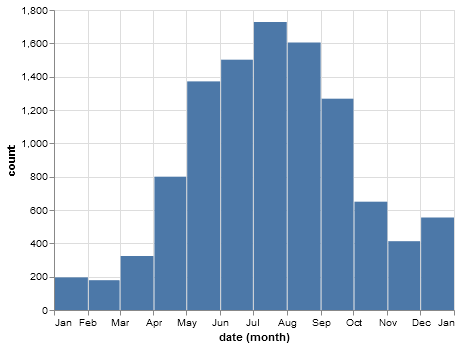

In [8]:
Image('images/taxa_by_month.png')

### Show number of observers per month

In [9]:
observers_by_month = get_monthly_counts(get_observation_observers, 'Observers')
alt.Chart(observers_by_month).mark_bar().encode(x='month(date):T', y='count:Q')

Total results for Jan: 36
Total results for Feb: 41
Total results for Mar: 71
Total results for Apr: 140
Total results for May: 361
Total results for Jun: 456
Total results for Jul: 529
Total results for Aug: 562
Total results for Sep: 404
Total results for Oct: 173
Total results for Nov: 85
Total results for Dec: 50


alt.Chart(...)

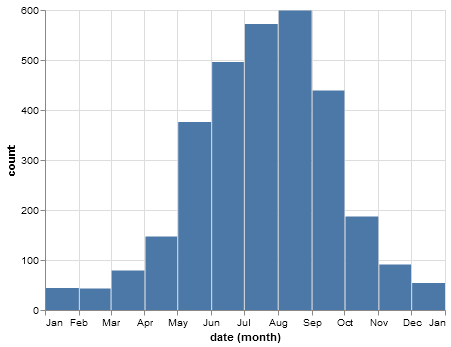

In [10]:
Image('images/observers_by_month.png')

### Show number of identifiers per month

In [11]:
identifiers_by_month = get_monthly_counts(get_observation_identifiers, 'Identifiers')
alt.Chart(identifiers_by_month).mark_bar().encode(x='month(date):T', y='count:Q')

Total results for Jan: 134
Total results for Feb: 149
Total results for Mar: 184
Total results for Apr: 349
Total results for May: 618
Total results for Jun: 585
Total results for Jul: 661
Total results for Aug: 615
Total results for Sep: 490
Total results for Oct: 314
Total results for Nov: 216
Total results for Dec: 206


alt.Chart(...)

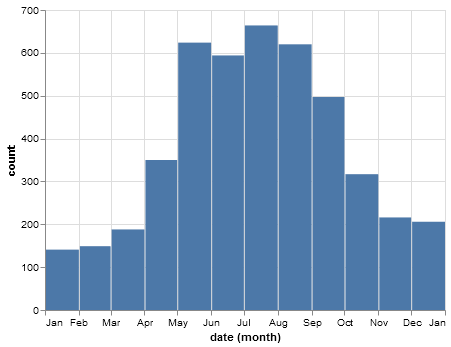

In [12]:
Image('images/identifiers_by_month.png')

### Combine all four metrics into one chart

In [13]:
combined_results = observations_by_month.append([taxa_by_month, observers_by_month, identifiers_by_month])


alt.Chart(
    combined_results,
    title=f'iNaturalist activity in {PLACE_NAME} ({YEAR})',
    width=750,
    height=500,
).mark_line().encode(
    alt.X('month(date):T', axis=alt.Axis(title="Month")),
    alt.Y('count:Q', axis=alt.Axis(title="Count")),
    color='metric',
    strokeDash='metric',
).configure_axis(
    labelFontSize=15,
    titleFontSize=20,
)

alt.Chart(...)

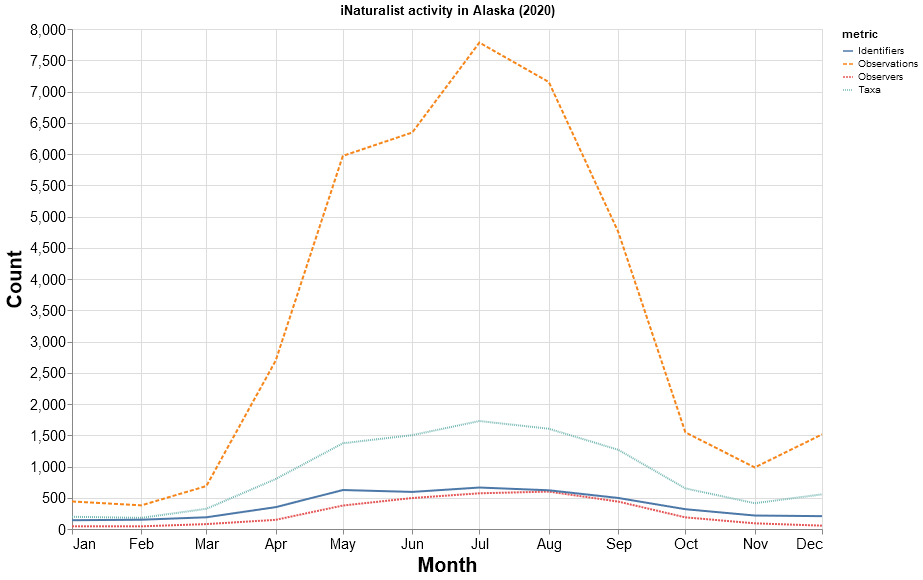

In [14]:
Image('images/combined_activity_stats.png')